In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import clip
from torch.nn import functional as F
import torch.nn as nn
from torchvision import transforms
from PIL import Image
train = False
classes = None
pictures= None

def load_data():
    data_list = []
    label_list = []
    texts = []
    images = []

    if train:
        text_directory = "/content/drive/MyDrive/testforthat/THINGS-EEG_images_set/training_images"
    else:
        text_directory = "/content/drive/MyDrive/testforthat/THINGS-EEG_images_set/test_images"

    dirnames = [d for d in os.listdir(text_directory) if os.path.isdir(os.path.join(text_directory, d))]
    dirnames.sort()

    if classes is not None:
        dirnames = [dirnames[i] for i in classes]

    for dir in dirnames:

        try:
            idx = dir.index('_')
            description = dir[idx+1:]
        except ValueError:
            print(f"Skipped: {dir} due to no '_' found.")
            continue

        new_description = f"{description}"
        texts.append(new_description)

    if train:
        img_directory = "/content/drive/MyDrive/testforthat/THINGS-EEG_images_set/"
    else:
        img_directory ="/content/drive/MyDrive/testforthat/THINGS-EEG_images_set/test_images"

    all_folders = [d for d in os.listdir(img_directory) if os.path.isdir(os.path.join(img_directory, d))]
    all_folders.sort()

    if classes is not None and pictures is not None:
        images = []
        for i in range(len(classes)):
            class_idx = classes[i]
            pic_idx = pictures[i]
            if class_idx < len(all_folders):
                folder = all_folders[class_idx]
                folder_path = os.path.join(img_directory, folder)
                all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
                all_images.sort()
                if pic_idx < len(all_images):
                    images.append(os.path.join(folder_path, all_images[pic_idx]))
    elif classes is not None and pictures is None:
        images = []
        for i in range(len(classes)):
            class_idx = classes[i]
            if class_idx < len(all_folders):
                folder = all_folders[class_idx]
                folder_path = os.path.join(img_directory, folder)
                all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
                all_images.sort()
                images.extend(os.path.join(folder_path, img) for img in all_images)
    elif classes is None:
        images = []
        for folder in all_folders:
            folder_path = os.path.join(img_directory, folder)
            all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
            all_images.sort()
            images.extend(os.path.join(folder_path, img) for img in all_images)
    else:

        print("Error")
    return texts, images
texts, images = load_data()
# images

In [ ]:
%cd /content/drive/MyDrive/testforthat/EEG_Image_decode-main/Generation/

/content/drive/MyDrive/testforthat/EEG_Image_decode-main/Generation


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/testforthat/EEG_Image_decode-main/Generation')

In [ ]:
import os

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

os.environ["WANDB_API_KEY"] = "KEY"
os.environ["WANDB_MODE"] = 'offline'
from itertools import combinations

import clip
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import tqdm
from eegdatasets_leaveone import EEGDataset

from einops.layers.torch import Rearrange, Reduce

from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
import random
from util import wandb_logger
from braindecode.models import EEGNetv4, ATCNet, EEGConformer, EEGITNet, ShallowFBCSPNet
import csv
from torch import Tensor
import itertools
import math
import re
from subject_layers.Transformer_EncDec import Encoder, EncoderLayer
from subject_layers.SelfAttention_Family import FullAttention, AttentionLayer
from subject_layers.Embed import DataEmbedding
import numpy as np
from loss import ClipLoss, FeatureContrastLoss
import argparse
from torch import nn
from torch.optim import AdamW
from pytorch_wavelets import DWT1DForward, DWT1DInverse

class WaveBlock(nn.Module):
    def __init__(self, c_in, c_out):
        super(WaveBlock, self).__init__()
        self.dwt = DWT1DForward(J=1, wave='db1', mode='zero')
        self.dwt.to('cuda')
        self.conv = nn.Conv1d(c_in, c_out, 3, 1, padding=1)
    def forward(self, x):
        xl, xh = self.dwt(x)

        x2 = torch.cat((xl, xh[0]), dim=-1)
        x3 = self.conv(x2)
        return x3

class iWaveBlock(nn.Module):
    def __init__(self, c_in, c_out):
        super(iWaveBlock, self).__init__()

        self.idwt = DWT1DInverse(wave='db1', mode='zero')
        self.idwt.to('cuda')

    def forward(self, x ):
        xl, xh = torch.split(x, [128, 128], dim=-1)
        x4 = self.idwt([xl, [xh]])
        return x4


class Config:
    def __init__(self):
        self.task_name = 'classification'  # Example task name
        self.seq_len = 250  # Sequence length
        self.pred_len = 256  # Prediction length
        self.output_attention = False  # Whether to output attention weights
        self.d_model = 256  # Model dimension
        self.embed = 'timeF'  # Time encoding method
        self.freq = 'h'  # Time frequency
        self.dropout = 0.25  # Dropout rate
        self.factor = 1  # Attention scaling factor
        self.n_heads = 4  # Number of attention heads
        self.e_layers = 1  # Number of encoder layers
        self.d_ff = 256  # Feedforward network dimension
        self.activation = 'gelu'  # Activation function
        self.enc_in = 63  # Encoder input dimension (example value)



class iTransformer(nn.Module):
    def __init__(self, configs, joint_train=False, num_subjects=10):
        super(iTransformer, self).__init__()
        self.task_name = configs.task_name
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.output_attention = configs.output_attention
        # Embedding
        self.enc_embedding = DataEmbedding(configs.seq_len, configs.d_model, configs.embed, configs.freq,
                                           configs.dropout, joint_train=False, num_subjects=num_subjects)

        self.dwt = WaveBlock(64, 64)
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(False, configs.factor, attention_dropout=configs.dropout,
                                      output_attention=configs.output_attention),
                        configs.d_model, configs.n_heads
                    ),
                    configs.d_model,
                    configs.d_ff,
                    dropout=configs.dropout,
                    activation=configs.activation
                ) for l in range(configs.e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(configs.d_model)
        )
        self.local_conv_time = nn.Conv1d(63, 63, kernel_size=3, padding=3 // 2,
                                         groups=63)
        # Cross-electrode convolution
        self.local_conv_electrode = nn.Conv2d(1, 1, kernel_size=(3, 1), padding=(3 // 2, 0),
                                              groups=1)
        self.gate = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(63, 63, 1),
            nn.Sigmoid()
        )

        self.idwt = iWaveBlock(63, 63)
        self.conv = nn.Conv1d(63, 63, 4, 2, padding=1)
    def forward(self, x_enc, x_mark_enc, subject_ids=None):
        # Embedding
        enc_out = self.enc_embedding(x_enc, x_mark_enc, subject_ids)
        a = self.dwt(enc_out)
        a = a[:, :63, :]
        local_time = self.local_conv_time(a)
        local_time_expanded = local_time.unsqueeze(1)  # (Batch, 1, Channels, Signal_Length)
        local_electrode = self.local_conv_electrode(local_time_expanded).squeeze(1)  # (Batch, Channels, Signal_Length)
        out, attns = self.encoder(a, attn_mask=None)
        out = out[:, :63, :]
        weight = self.gate(a)  # (Batch, Channels, 1)
        out = local_electrode * (1 - weight) + out * weight
        b = self.idwt(out)
        c = self.conv(torch.cat([out, b], dim=-1))
        #print("c", c.shape)
        return c


class PrintShape(nn.Module):
    def __init__(self, name):
        super().__init__()
        self.name = name

    def forward(self, x):
        print(f"{self.name} shape: {x.shape}")
        return x


class MultiBranchNet(nn.Module):
    def __init__(self,
                 in_channels=63,
                 n_filters1=40,
                 n_filters2=40,
                 dropout_rate=0.5):
        super().__init__()

        self.temporal_branch = nn.Sequential(
            nn.Conv2d(in_channels, n_filters1, kernel_size=(1, 25), padding='same'),
            nn.BatchNorm2d(n_filters1),
            nn.ELU(),
            nn.AvgPool2d((1, 4), stride=(1, 2)),
            nn.Dropout(dropout_rate),
            nn.Conv2d(n_filters1, n_filters1, kernel_size=(1, 1)),
            nn.BatchNorm2d(n_filters1),
            nn.ELU(),
            nn.AdaptiveAvgPool2d((1, 37))
        )

        self.spatial_branch = nn.Sequential(
            nn.Conv2d(in_channels, n_filters1, kernel_size=(3, 1), padding=(1, 0)),
            nn.BatchNorm2d(n_filters1),
            nn.ELU(),
            nn.Conv2d(n_filters1, n_filters1 * 2, kernel_size=(3, 3),
                      padding='same', groups=n_filters1),
            nn.BatchNorm2d(n_filters1 * 2),
            nn.ELU(),
            nn.Conv2d(n_filters1 * 2, n_filters1, kernel_size=1),
            nn.BatchNorm2d(n_filters1),
            nn.ELU(),
            nn.AdaptiveAvgPool2d((1, 37))
        )

        self.fusion_branch = nn.Sequential(
            nn.Conv2d(n_filters1 * 2, n_filters2, kernel_size=1),
            nn.BatchNorm2d(n_filters2),
            nn.ELU(),
            nn.Dropout(dropout_rate),
            nn.AdaptiveAvgPool2d((1, 37))
        )

        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(n_filters1 * 2, n_filters1 // 2, kernel_size=1),
            nn.ELU(),
            nn.Conv2d(n_filters1 // 2, n_filters1 * 2, kernel_size=1),
            nn.Sigmoid()
        )

        self.projection = nn.Sequential(
            nn.Conv2d(40, 40, (1, 1), stride=(1, 1)),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )

    def forward(self, x):
        x = x.unsqueeze(2)
        temporal_features = self.temporal_branch(x)
        spatial_features = self.spatial_branch(x)
        combined_features = torch.cat([temporal_features, spatial_features], dim=1)
        attention_weights = self.attention(combined_features)
        weighted_features = combined_features * attention_weights
        output = self.fusion_branch(weighted_features)
        output = self.projection(output)

        return output


class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, kernel_size=kernel_size,
            padding='same', groups=in_channels
        )
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x



class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FlattenHead(nn.Sequential):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        return x


class Enc_eeg(nn.Sequential):
    def __init__(self, emb_size=40, **kwargs):
        super().__init__(
            MultiBranchNet(),
            FlattenHead()
        )


class Proj_eeg(nn.Sequential):
    def __init__(self, embedding_dim=1480, proj_dim=1024, drop_proj=0.5):
        super().__init__(
            nn.Linear(embedding_dim, proj_dim),
            ResidualAdd(nn.Sequential(
                nn.GELU(),
                nn.Linear(proj_dim, proj_dim),
                nn.Dropout(drop_proj),
            )),
            nn.LayerNorm(proj_dim),
        )


def extract_id_from_string(s):
    match = re.search(r'\d+$', s)
    if match:
        return int(match.group())
    return None


class ATMDWT(nn.Module):
    def __init__(self, num_channels=63, sequence_length=250, num_subjects=1, num_features=64, num_latents=2048,
                 num_blocks=1):
        super(ATMDWT, self).__init__()
        default_config = Config()
        self.encoder = iTransformer(default_config)
        self.subject_wise_linear = nn.ModuleList(
            [nn.Linear(default_config.d_model, sequence_length) for _ in range(num_subjects)])
        self.enc_eeg = Enc_eeg()
        self.proj_eeg = Proj_eeg()
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        self.loss_func = ClipLoss()
        self.loss2 = FeatureContrastLoss()

    def forward(self, x, subject_ids):
        x = self.encoder(x, None, subject_ids)
        # print(f'After attention shape: {x.shape}')
        # print("x", x.shape)
        # x = self.subject_wise_linear[0](x)
        # print(f'After subject-specific linear transformation shape: {x.shape}')
        eeg_embedding = self.enc_eeg(x)

        out = self.proj_eeg(eeg_embedding)
        return out


def get_eegfeatures_test(sub, eegmodel, dataloader, device, text_features_all, img_features_all):
    eegmodel.eval()
    text_features_all = text_features_all.to(device).float()
    img_features_all = img_features_all.to(device).float()
    total_loss = 0
    correct = 0
    total = 0
    alpha =0.9
    beta = 0.9
    top5_correct = 0
    top5_correct_count = 0

    all_labels = set(range(text_features_all.size(0)))
    top5_acc = 0
    mse_loss_fn = nn.MSELoss()
    loss_CF = FeatureContrastLoss()
    ridge_lambda = 0.1
    save_features = True
    features_list = []  # List to store features
    with torch.no_grad():
        for batch_idx, (eeg_data, labels, text, text_features, img, img_features) in enumerate(dataloader):
            print(eeg_data.shape)
            eeg_data = eeg_data.to(device)
            text_features = text_features.to(device).float()
            labels = labels.to(device)
            img_features = img_features.to(device).float()

            batch_size = eeg_data.size(0)  # Assume the first element is the data tensor
            subject_id = extract_id_from_string(sub)
            # eeg_data = eeg_data.permute(0, 2, 1)
            subject_ids = torch.full((batch_size,), subject_id, dtype=torch.long).to(device)

            eeg_features = eeg_model(eeg_data, subject_ids)
            features_list.append(eeg_features.cpu())

            logit_scale = eeg_model.logit_scale

            regress_loss =  mse_loss_fn(eeg_features, img_features)
            img_loss = eegmodel.loss_func(eeg_features, img_features, logit_scale)
            text_loss = eegmodel.loss_func(eeg_features, text_features, logit_scale)
            contrastive_loss = img_loss
            regress_loss =  mse_loss_fn(eeg_features, img_features)
            loss = alpha * regress_loss *10 + (1 - alpha) * contrastive_loss*10
            loss = beta * loss + (1 - beta) * loss_CF(eeg_features, labels)
            # print("loss", loss)
            total_loss += loss.item()

            for idx, label in enumerate(labels):

                possible_classes = list(all_labels - {label.item()})
                selected_classes = random.sample(possible_classes, k-1) + [label.item()]
                selected_img_features = img_features_all[selected_classes]


                logits_img = logit_scale * eeg_features[idx] @ selected_img_features.T
                logits_single = logits_img

                predicted_label = selected_classes[torch.argmax(logits_single).item()] 
                if predicted_label == label.item():
                    correct += 1
                total += 1

        if save_features:
            features_tensor = torch.cat(features_list, dim=0)
            print("features_tensor", features_tensor.shape)
            torch.save(features_tensor.cpu(), f"20250103_ATM_S_eeg_features_{sub}-test.pt")  # Save features as .pt file
    average_loss = total_loss / (batch_idx+1)
    accuracy = correct / total
    return average_loss, accuracy, labels, features_tensor.cpu()

from IPython.display import Image, display
config = {
"data_path": "/content/drive/MyDrive/testforthat/EEG_Image_decode/Preprocessed_data_250Hz",
"name": "DWTGeneration_Task",
"lr": 3e-4,
"epochs": 50,
"batch_size": 1024,
"logger": True,
"encoder_type":'ATMDWT',
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_path = config['data_path']
emb_img_test = torch.load('/content/drive/MyDrive/testforthat/EEG_Image_decode-main/Generation/variables/ViT-H-14_features_test.pt')
emb_img_train = torch.load('/content/drive/MyDrive/testforthat/EEG_Image_decode-main/Generation/variables/ViT-H-14_features_train.pt')
eeg_model = ATMDWT(63, 250)
print('number of parameters:', sum([p.numel() for p in eeg_model.parameters()]))

#####################################################################################

eeg_model.load_state_dict(torch.load("/content/drive/MyDrive/testforthat/EEG_Image_decode-main/Generation/models/contrast/ATMS/sub8/15.pth"))
eeg_model = eeg_model.to(device)
sub = 'sub-08'
#####################################################################################


1


open_clip_pytorch_model.bin:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

<ipython-input-6-5c9b5ac618a9>:473: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emb_img_test = torch.load('/content/drive/MyDrive/testforthat/EEG_Image_decode-main/Generat

number of parameters: 3214978


<ipython-input-6-5c9b5ac618a9>:482: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  eeg_model.load_state_dict(torch.load("/content/drive/MyDrive/testforthat/EEG_Image_decode-m

In [ ]:
test_dataset = EEGDataset(data_path, subjects= [sub], train=False)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=0)
text_features_test_all = test_dataset.text_features
img_features_test_all = test_dataset.img_features
test_loss, test_accuracy,labels, eeg_features_test = get_eegfeatures_test(sub, eeg_model, test_loader, device, text_features_test_all, img_features_test_all)
print(f" - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

self.subjects ['sub-08']
exclude_subject None


KeyboardInterrupt: 

In [ ]:

def get_eegfeatures_train(sub, eegmodel, dataloader, device, text_features_all, img_features_all, k):
    eegmodel.eval()
    text_features_all = text_features_all.to(device).float()
    img_features_all = img_features_all.to(device).float()
    total_loss = 0
    correct = 0
    total = 0
    alpha =0.9
    beta = 0.9
    top5_correct = 0
    top5_correct_count = 0

    all_labels = set(range(text_features_all.size(0)))
    top5_acc = 0
    mse_loss_fn = nn.MSELoss()
    loss_CF = FeatureContrastLoss()
    ridge_lambda = 0.1
    save_features = True
    features_list = []  # List to store features
    with torch.no_grad():
        for batch_idx, (eeg_data, labels, text, text_features, img, img_features) in enumerate(dataloader):
            print(eeg_data.shape)
            eeg_data = eeg_data.to(device)
            text_features = text_features.to(device).float()
            labels = labels.to(device)
            img_features = img_features.to(device).float()

            batch_size = eeg_data.size(0)  # Assume the first element is the data tensor
            subject_id = extract_id_from_string(sub)
            subject_ids = torch.full((batch_size,), subject_id, dtype=torch.long).to(device)
            eeg_features = eeg_model(eeg_data, subject_ids)
            features_list.append(eeg_features.cpu())

            logit_scale = eeg_model.logit_scale

            regress_loss =  mse_loss_fn(eeg_features, img_features)
            img_loss = eegmodel.loss_func(eeg_features, img_features, logit_scale)
            contrastive_loss = img_loss
            regress_loss =  mse_loss_fn(eeg_features, img_features)
            loss = alpha * regress_loss *10 + (1 - alpha) * contrastive_loss*10
            loss = beta * loss + (1 - beta) * loss_CF(eeg_features, labels)
            total_loss += loss.item()

            for idx, label in enumerate(labels):

                possible_classes = list(all_labels - {label.item()})
                selected_classes = random.sample(possible_classes, k-1) + [label.item()]
                selected_img_features = img_features_all[selected_classes]


                logits_img = logit_scale * eeg_features[idx] @ selected_img_features.T
                logits_single = logits_img
                predicted_label = selected_classes[torch.argmax(logits_single).item()] # (n_batch, ) \in {0, 1, ..., n_cls-1}
                if predicted_label == label.item():
                    correct += 1
                total += 1

        if save_features:
            features_tensor = torch.cat(features_list, dim=0)
            print("features_tensor", features_tensor.shape)
            torch.save(features_tensor.cpu(), f"20250103_ATM_S_eeg_features_{sub}.pt")  # Save features as .pt file
    average_loss = total_loss / (batch_idx+1)
    accuracy = correct / total
    return average_loss, accuracy, labels, features_tensor.cpu()

#####################################################################################
train_dataset = EEGDataset(data_path, subjects= [sub], train=True)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=0)
text_features_test_all = train_dataset.text_features
img_features_test_all = train_dataset.img_features

train_loss, train_accuracy, labels, eeg_features_train = get_eegfeatures_train(sub, eeg_model, train_loader, device, text_features_test_all, img_features_test_all,k=200)
print(f" - Test Loss: {train_loss:.4f}, Test Accuracy: {train_accuracy:.4f}")
#####################################################################################

self.subjects ['sub-10']
exclude_subject None
data_tensor torch.Size([66160, 63, 250])
Data tensor shape: torch.Size([66160, 63, 250]), label tensor shape: torch.Size([66160]), text length: 1654, image length: 16540
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])
torch.Size([1024, 63, 250])


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import open_clip
from matplotlib.font_manager import FontProperties

import sys
from diffusion_prior import *
# os.environ["CUDA_VISIBLE_DEVICES"] = "5"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
emb_img_train_4 = emb_img_train.view(1654,10,1,1024).repeat(1,1,4,1).view(-1,1024)
emb_eeg = torch.load(f'/content/drive/MyDrive/testforthat/EEG_Image_decode-main/Generation/20250103_ATM_S_eeg_features_{sub}.pt')
emb_eeg_test = torch.load(f'/content/drive/MyDrive/testforthat/EEG_Image_decode-main/Generation/20250103_ATM_S_eeg_features_{sub}-test.pt')

<ipython-input-42-fabb385f7f1b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emb_eeg = torch.load(f'/content/drive/MyDrive/testforthat/EEG_Image_decode-main/Generation/2

In [ ]:
dataset = EmbeddingDataset(
    c_embeddings=eeg_features_train, h_embeddings=emb_img_train_4,
    # h_embeds_uncond=h_embeds_imgnet
)

dl = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=64)

In [ ]:

diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
# number of parameters
print(sum(p.numel() for p in diffusion_prior.parameters() if p.requires_grad))
pipe = Pipe(diffusion_prior, device=device)

# load pretrained model
model_name = 'diffusion_prior' 
#pipe.train(dl, num_epochs=150, learning_rate=1e-3) # to 0.142
string = f'/content/drive/MyDrive/testforthat/EEG_Image_decode/fintune_ckpts/{sub}/{model_name}.pt'
pipe.diffusion_prior.load_state_dict(torch.load(string, map_location=device))

9675648


<ipython-input-44-85ba6daa8aa8>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pipe.diffusion_prior.load_state_dict(torch.load(string, map_location=device))


<All keys matched successfully>

In [ ]:
from custom_pipeline import *
# Create the directory if it doesn't exist
from PIL import Image
import os

# Assuming generator.generate returns a PIL Image
generator = Generator4Embeds(num_inference_steps=4, device=device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:

directory = f"generated_imgs/new/{sub}"
os.makedirs(directory, exist_ok=True)
for k in range(200):
    eeg_embeds = emb_eeg_test[k:k+1]
    h = pipe.generate(c_embeds=eeg_embeds, num_inference_steps=50, guidance_scale=5.0)
    for j in range(10):
        image = generator.generate(h.to(dtype=torch.float16))
        # Construct the save path for each image
        path = f'{directory}/{texts[k]}/{j}.png'
        # Ensure the directory exists
        os.makedirs(os.path.dirname(path), exist_ok=True)
        # Save the PIL Image
        image.save(path)
        print(f'Image saved to {path}')

50it [00:00, 151.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/new/sub-08/aircraft_carrier/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/new/sub-08/aircraft_carrier/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/new/sub-08/aircraft_carrier/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/new/sub-08/aircraft_carrier/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/new/sub-08/aircraft_carrier/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

50it [00:00, 143.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

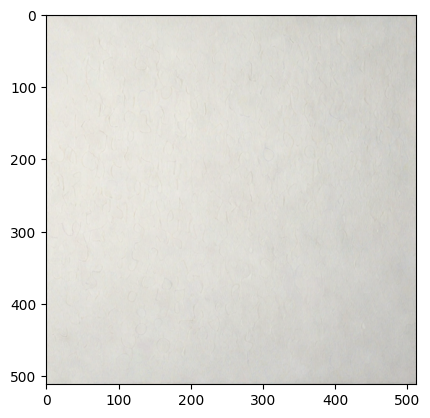

In [ ]:
h = pipe.generate(c_embeds=eeg_feature, num_inference_steps=50, guidance_scale=5.0)
for j in range(10):
    image = generator.generate(h.to(dtype=torch.float16))
    plt.imshow(image)